In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from rms import STSP, Planet, Spot, Star
from scipy.stats import ks_2samp, anderson_ksamp

In [27]:
p = Planet.non_transiting()

n_stars = 300
n_times = 20

n_spots = 3
p_rot = 1.88
spot_radii = 0.2 #0.32
amps_fast = np.loadtxt('data/lowmass_fast.txt')

print('spot area:', n_spots * np.pi*spot_radii**2 / (4*np.pi))

times = Time(np.linspace(0, p_rot, n_times), format='jd')

def ks(spot_radii, amps, n_stars=n_stars, n_spots=n_spots):
    ptp = []

    for _ in range(n_stars):
        random_inc = 180*np.random.rand() - 90
        star = Star(p, rotation_period=p_rot, spot_contrast=0.7, 
                    inc_stellar=random_inc, u=[0.5079, 0.2239])

        spots = []
        for _ in range(n_spots): 
            random_lat = (20*np.random.rand() + 70)*u.deg
            random_lon = 360*np.random.rand()*u.deg
            spots.append(Spot(random_lat, random_lon, spot_radii))
    
        with STSP(times, star, spots) as s: 
            lc = s.generate_lightcurve(n_ld_rings=5)
            ptp.append(100 * lc.fluxes.ptp())
            
    #stat = ks_2samp(ptp, amps).statistic
    stat = anderson_ksamp([ptp, amps]).statistic
    
    return stat, ptp

radii_fast = np.arange(0.1, 0.5, 0.05)

stats = []
spots = np.array([3, 4, 5, 6, 7])
for n_spots in spots: 
    stats_fast = []
    for spot_radii in radii_fast:

        stat, ptp = ks(spot_radii, amps_fast, n_spots=n_spots)

        stats_fast.append(stat)
    stats.append(stats_fast)

spot area: 0.030000000000000006


In [30]:
np.array(stats)

array([[ 125.94029948,   86.7153908 ,   36.0828573 ,    5.52333789,
           4.40952224,   11.98747771,   34.26688698,   41.47154407],
       [ 125.301056  ,   74.34658123,   30.27859103,    4.51662512,
           3.975438  ,    9.71224575,   26.96432237,   46.51482207],
       [ 123.7290409 ,   74.37860501,   28.23299602,    4.03090329,
           1.56421221,   19.83720557,   34.61280228,   43.18254368],
       [ 120.22044917,   72.29640156,   28.60636366,    4.58896477,
           2.70607209,   11.94389464,   36.42405532,   49.09649883],
       [ 116.33233803,   75.82506012,   33.37534727,    3.84809108,
           6.02201557,   18.71572499,   23.53123919,   50.46433712]])

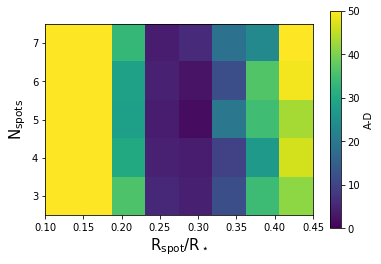

In [38]:
# plt.plot(radii_fast, stats_fast)
# plt.xlabel('Spot Radius')
# plt.ylabel('A-D Statistic')

cax = plt.imshow(stats, origin='lower', 
                 extent=[radii_fast.min(), radii_fast.max(), spots.min()-0.5, spots.max()+0.5], 
                 aspect=0.05, vmin=0, vmax=50)
cbar = plt.colorbar(cax)
cbar.set_label('A-D')
plt.xlabel('$\\rm R_{spot}/R_\star$', fontsize=15)
plt.ylabel('$\\rm N_{spots}$', fontsize=15)
plt.savefig('plots/grid.pdf')